In [2]:
#导入包
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

C:\Users\nzn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


# 英文数据集

In [5]:
#下载数据集
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data('imdb.npz',num_words=15000)
#如果下载失败，可以将npz文件放到C:\Users\nzn\.keras\datasets下

In [6]:
#以整数形式存储，转为文字
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 1s 0us/step


In [7]:
decode_review(train_data[20])

"<START> shown in australia as <UNK> this incredibly bad movie is so bad that you become <UNK> and have to watch it to the end just to see if it could get any worse and it does the storyline is so predictable it seems written by a high school <UNK> class the sets are pathetic but marginally better than the <UNK> and the acting is wooden br br the infant <UNK> seems to have been stolen from the props <UNK> of <UNK> <UNK> there didn't seem to be a single original idea in the whole movie br br i found this movie to be so bad that i laughed most of the way through br br malcolm mcdowell should hang his head in shame he obviously needed the money"

# Prepare the data

### 评论 - 整数数组 - 必须在输入神经网络之前转换为张量。 这种转换可以通过以下几种方式完成：

对数组进行单热编码，将其转换为0和1的向量。 例如，序列[3,5]将成为10,000维向量，除了索引3和5（它们是1）之外全部为零。 然后，将其作为我们网络中的第一层 - 一个可以处理浮点矢量数据的Dense层。 但是，这种方法是内存密集型的，需要num_words * num_reviews大小矩阵。

或者，我们可以填充数组，使它们都具有相同的长度，然后创建一个整数张数形状num_examples * max_length。 我们可以使用能够将此形状作为我们网络中第一层的嵌入层。

在本教程中，我们将使用第二种方法。

由于电影评论的长度必须相同，我们将使用pad_sequences函数来标准化长度：


In [11]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

### 填充序列pad_sequences
keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32',
    padding='pre', truncating='pre', value=0.)
将长为nb_samples的序列（标量序列）转化为形如(nb_samples,nb_timesteps)2D numpy array。如果提供了参数maxlen，nb_timesteps=maxlen，否则其值为最长序列的长度。其他短于该长度的序列都会在后部填充0以达到该长度。长于nb_timesteps的序列将会被截断，以使其匹配目标长度。padding和截断发生的位置分别取决于padding和truncating.

参数
sequences：浮点数或整数构成的两层嵌套列表

maxlen：None或整数，为序列的最大长度。大于此长度的序列将被截短，小于此长度的序列将在后部填0.

dtype：返回的numpy array的数据类型

padding：‘pre’或‘post’，确定当需要补0时，在序列的起始还是结尾补

truncating：‘pre’或‘post’，确定当需要截断序列时，从起始还是结尾截断

value：浮点数，此值将在填充时代替默认的填充值0

返回值
返回形如(nb_samples,nb_timesteps)的2D张量

In [12]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [13]:
print(train_data[0])

[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670     2     9    35   480   284     5   150     4   172   112
   167     2   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18     2     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4     2     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4 12118  1029    13   104    88     4   381   

# Build the model

In [14]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 15000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
#model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          240000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 240,289
Trainable params: 240,289
Non-trainable params: 0
_________________________________________________________________



第一层是嵌入层。 该层采用整数编码的词汇表，并查找每个词索引的嵌入向量。 这些向量是作为模型训练学习的。 向量为输出数组添加维度。 生成的维度为:(批处理，序列，嵌入）。
接下来，GlobalAveragePooling1D层通过对序列维度求平均，为每个示例返回固定长度的输出向量。 这允许模型以最简单的方式处理可变长度的输入。
该固定长度输出矢量通过具有16个隐藏单元的完全连接（密集）层进行管道传输。
最后一层与单个输出节点密集连接。 使用sigmoid激活函数，此值是介于0和1之间的浮点数，表示概率或置信度。

In [15]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
#验证集
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# Train the model

In [17]:
#回调函数。每一Epochs都进行F1计算
import numpy as np
from keras.callbacks import Callback
from keras.engine.training import Model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict,average='weighted')
        _val_recall = recall_score(val_targ, val_predict,average='weighted')
        _val_precision = precision_score(val_targ, val_predict,average='weighted')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print( ' — val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        return
    
metrics = Metrics()

Using TensorFlow backend.


In [18]:
from keras.callbacks import EarlyStopping
earlystopping=keras.callbacks.EarlyStopping(monitor='val_acc', patience=8, verbose=0, mode='max')

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=90,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[metrics,earlystopping],
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/90
15000/15000 [==============================] - 9s 617us/step - loss: 0.6926 - acc: 0.5233 - val_loss: 0.6917 - val_acc: 0.5276
Epoch 2/90
15000/15000 [==============================] - 4s 275us/step - loss: 0.6901 - acc: 0.5981 - val_loss: 0.6883 - val_acc: 0.7243
Epoch 3/90
15000/15000 [==============================] - 2s 149us/step - loss: 0.6842 - acc: 0.6670 - val_loss: 0.6799 - val_acc: 0.7354
Epoch 4/90
15000/15000 [==============================] - 2s 149us/step - loss: 0.6708 - acc: 0.7093 - val_loss: 0.6637 - val_acc: 0.7702
Epoch 5/90
15000/15000 [==============================] - 3s 168us/step - loss: 0.6493 - acc: 0.7359 - val_loss: 0.6384 - val_acc: 0.7906
Epoch 6/90
15000/15000 [==============================] - 2s 147us/step - loss: 0.6188 - acc: 0.7543 - val_loss: 0.6034 - val_acc: 0.8014
Epoch 7/90
15000/15000 [==============================] - 2s 162us/step - loss: 0.5766 - acc: 0.7835 - val_loss: 0.5596 - 

Epoch 29/90
15000/15000 [==============================] - 2s 149us/step - loss: 0.1629 - acc: 0.9519 - val_loss: 0.2790 - val_acc: 0.8885
Epoch 30/90
15000/15000 [==============================] - 2s 148us/step - loss: 0.1579 - acc: 0.9531 - val_loss: 0.2801 - val_acc: 0.8891
Epoch 31/90
15000/15000 [==============================] - 3s 176us/step - loss: 0.1495 - acc: 0.9571 - val_loss: 0.2811 - val_acc: 0.8895
Epoch 32/90
15000/15000 [==============================] - 2s 143us/step - loss: 0.1443 - acc: 0.9601 - val_loss: 0.2830 - val_acc: 0.8891
Epoch 33/90
15000/15000 [==============================] - 2s 162us/step - loss: 0.1381 - acc: 0.9607 - val_loss: 0.2843 - val_acc: 0.8888
Epoch 34/90
15000/15000 [==============================] - 2s 152us/step - loss: 0.1319 - acc: 0.9655 - val_loss: 0.2866 - val_acc: 0.8885
Epoch 35/90
15000/15000 [==============================] - 2s 144us/step - loss: 0.1304 - acc: 0.9646 - val_loss: 0.2883 - val_acc: 0.8871
Epoch 36/90
15000/15000 [==

# Evaluate the model

In [19]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 39us/step
[0.32365488556861877, 0.8758]


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

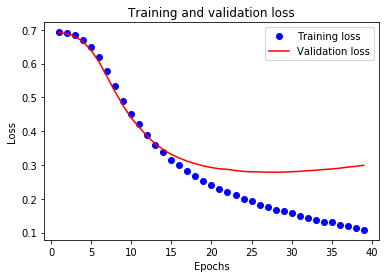

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

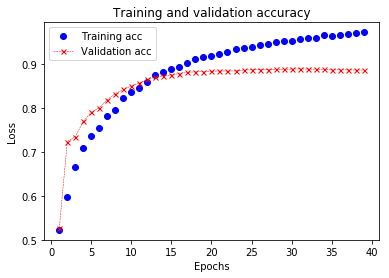

In [23]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, color='red', marker='x', linestyle='dashed',
        linewidth=0.5, markersize=5,label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

####   
这不是验证损失和准确性的情况 - 它们似乎在大约十五个迭代之后达到峰值。 

这是过度拟合的一个例子。 在此之后，模型过度优化并学习特定于训练数据的表示，这些表示不会推广到测试数据。

对于这种特殊情况，我们可以通过在二十个左右的时期之后停止训练来防止过度拟合。